# Transformer Fine-Tuning Notebook

---

### Project Overview

This research focuses on mechanistic interpretability experiments concerning the universality hypothesis -- that different model's trained on the same task will converge to similar internal representations -- as it relates to SOTA segmentation models. We are particularly interested in the hypothesis' applicability in large scale models because so far current research has either focussed on small models as toy experiments or large scale language models. That is, until now there is no work that examines universality in large scale segmentation models.

Therefore, mask2former and unet++ were chosen to test universality. These are both large scale models that provide SOTA performance on many common segmentation tasks and are readily available. The choice of a CNN and transformer based model is intentional. We need contrasting architectures to test universality: we want to see if both a transformer based segmentation model and a CNN based segmentation model will converge to similar internal representations in order to solve the same task. If they do, we will have shown that universality applies.

The task used will be binary segmentation of medical images containing moles and skin legions. The ISIC 2018 dataset will be used due to its relatively small size, availability, and commonality. Both models will be fine-tuned on the same task. We will keep the encoder frozen to take advantage of the extensive pre-training available for both models and make the experiments reproducible. Therefore, mechanistic interepretabiltiy experiments will focus on the fine-tuned decoder as it will be the only component guaranteed to have been trained on the same task, and therefore, the only component that can either demonstrate the presence or absence of universality.

<br>

---
<br>

### Transformer Notebook

This notebook contains the code to fine-tune mask2former --the transformer based model. The notebook calls on many files that are listed in the LOCAL IMPORTS section. The local imports are all custom-written classes and functions while imports are external libraries. Most functions calls are to local imports. All methods and classes use pydocs so simply hover over them if you would like more details or to know which file to navigate to.

All sections will also include markdown formatting before in order to explain the logic, decisions, and results.



<br>
<br>
<br>

### Google Colab Mounting and Data Downloading

This cell is for using google colab which is recommended because mechanistic interpretability experiments on transformer based models can cause large spikes in RAM. This is because the flattening and norm operations can result is disproportionately large tensors that will cause memory spikes when processing for scalar comparisons.

The code mounts your google drive and then unzips the data assuming your data is in the correct path location. Change the path if it is not. The ISIC 2018 dataset is over 15GB so it is recommended to keep it compressed in your google drive and use the script.

If you have better computational resources or are using other computing infrastructure feel free to ignore this component.

Google colab is used for simplicity and reproducibility.

In [ ]:
##############################################
# Google Colab Mounting and Data Downloading #
##############################################

# import zipfile
import zipfile

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# path to data
data_root = "/content/drive/MyDrive/data.zip"

# unzip data and store in content
with zipfile.ZipFile(data_root, 'r') as zip_ref:
    zip_ref.extractall('/content/data')


Mounted at /content/drive


### Imports

These are the base external dependencies for the entire project.

<br>

***Note:***    The fix possible truncation using PIL is necessary because unet++ does not have an image processor and pytorch may throw errors if images are truncated,

<br>

***Note:***    Although segmentation_models_pytorch is only necessary for unet++, certain external .py files require the dependency. You will need to have it installed in order to import these files which contain necessary methods.

In [ ]:
###########
# Imports #
###########

# install library for unet++
# not explicitly necessary but needed for dependencies
!pip install segmentation_models_pytorch

import segmentation_models_pytorch as smp
from transformers import Mask2FormerForUniversalSegmentation, Mask2FormerImageProcessor
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image, ImageFilter
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gc
from torch.nn.functional import conv2d
from tqdm import tqdm
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler


# fix possible truncation during training
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True




  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Local Imports

These imports are from the python files described above that contain all the necessary code for the research. All files are well documented using py docs so simply hover over method calls and classes for more information or navigation instructions. The files are all named appropriately: it is evident which functionality is contained where.

<br>

***Note*** Certain functions and classes in the python files are built for both unet++ and mask2former while others are independent and only work with one of the models such as the training, inference, and many utility functions. The sections are clearly separated within the python files.

<br>

***Note:*** the auto reload is not necessary. It is here because it makes altering the python files while working and running the jupyter notebook much easier. Your changes will be registered immediately This is for those that desire changing the code (working with another model for example or extending the research.)

<br>

***Note:*** change the path for the project files if your structure is different.

In [ ]:
#################
# Imports local #
#################

# auto reload for modules (get rid of old caches that cause errors)
%load_ext autoreload
%autoreload 2

# import correct path for project directory
sys.path.append('/content/drive/MyDrive/mech_interp_segmentation')

from utils import *
from dataset import *
from loss_metrics import *
from train import *
from inference import *
from visualization import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Loaders and Processing

The following first sets the path for the uncompressed data (change if necessary).

Then we call the necessary functions in order to create the data loaders for the test, validation, and training sets. The create_dataloaders function is in the dataset.py file and is actually composed of many methods and the Dataset class in that file. Please navigate to the file if interested in the data processing that is done implicitly when the method is called. When this function is called, all the images and masks are processed before creating the dataset and the subsequent data loaders. However, extensive pre-processing is not necessary because we use an image-processor for mask2former. Moreover, we are not interested in squeezing out an extra percent or two in accuracy metrics because the goal here is showing the absence or presence of universality. Therefore, good performance is sufficient in order to conduct the experiments. We do not need SOTA performance on ISIC 2018.

The following two methods are used to verify that the data has been processed and loaded properly. They display the processed images alongside their accompanying ground-truth masks. If these do not match (the general shapes should be easy to compare), then the data was not loaded properly, and your data is corrupted. The second method visualizes directly from the data loaders as an extra pre-caution.







In [ ]:
#################
# Data Loaders  #
#################

data_root = "/content/data/data"

# create all dataloaders at once
train_loader, val_loader, test_loader, train_images, val_images, test_images, train_masks, val_masks, test_masks = create_dataloaders(data_root, batch_size=16)

# verify data alignment for the training set using the train loader's dataset and train image/mask lists
verify_data_alignment(train_loader.dataset, train_images, train_masks, num_samples=5)

# visualize one batch from the training loader
visualize_batch_from_loader(train_loader, num_batches=1)

Output hidden; open in https://colab.research.google.com to view.

### Dataset Inspection and Cutting

Here we verify the dataset to further ensure that we have matching dimensions between all features and groud truths for each dataloader.

We then cut the test set in half. The ISIC test set is 1000 images while the training set is only 2594 images. The test set is 40% the size of the training set because this dataset is a challenge dataset. We are not interested in the challenge and therefore, only need a 20% split in order to properly gauge our model's performance. So our test set becomes 500 images. If you prefer work with the full test set, then simply delete or comment our this portion of the code.

In [ ]:
# inspect the dataset

# check for matching number of images and masks
assert len(train_images) == len(train_masks), "Mismatch between number of images and masks."
assert len(val_images) == len(val_masks), "Mismatch between number of images and masks."
assert len(test_images) == len(test_masks), "Mismatch between number of images and masks."

# print the number of images and masks in each set from dataloader
print(f"Number of training images: {len(train_loader.dataset)}")
print(f"Number of validation images: {len(val_loader.dataset)}")
print(f"Number of test images: {len(test_loader.dataset)}")

# cut test set in half
# ISIC uses 40% test set but we do not need this for our testing

# get indcies
test_dataset_size = len(test_loader.dataset)
half_size = test_dataset_size// 2
indices = list(range(half_size))  # take 50%

# ccreate subset of dataloader
test_subset = Subset(test_loader.dataset, indices)

# create new data loader
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=test_loader.batch_size, shuffle=False, num_workers=4, pin_memory=True)

# print the number of images and masks in the test set
print(f"\n\nNumber of test images after cutting: {len(test_loader.dataset)}")




Number of training images: 2594
Number of validation images: 100
Number of test images: 1000


Number of test images after cutting: 500


### Model Set Up

The following cell loads the mask2former model and image processor using methods from utils.py. Please navigate to the file if interested in the loading process or if you would like to alter parameters such as image downsampling (we are using 512x512).

We clear the model and cache for possible memory errors and considerations if the experiment needs to be restarted from scratch.

<br>

---

<br>

#### Freezing Encoder Layers

The encoder is frozen for both computational reasons and those mentioned in the project introduction at the top of this notebook. Moreover, having worked with mask2former before, re-training the encoder and losing the advantage of extensive pre-training does not lead to better performance on medical datasets of this size. The generalization capabilities that come from large scale pre-training for feature learning are not to be understated, and we would need significant computational resources as well as a much larger dataset to negate these advantages.

The print_trainable_layers function is also from utils.py and simply prints all the layers of the model for which gradients can be computed. That is, those layers which are not frozen. This function is also very useful for the mechanistic interpretability experiments because we will use it to list all the layers and choose the most important ones to extract features and activations from in order to compare to their closest counterparts in the CNN (unet++). Both models will need to have all their layers displayed (at least those that have been fine-tuned) in order to decide their correspondences and being selective on those that should be used for experiments. Running experiments on the outputs of all layers would not only be infeasible but also unproductive because we need those that can

1. compare to their counterparts in the other model
2. represent meaningful features in terms of the task

In [ ]:
#########################
#      MODEL SET UP     #
#########################

# clear existing model and optimizer (if any)
clear_model_and_cache()

# define model for both model and processor
pretrained_model_name = "facebook/mask2former-swin-base-IN21k-ade-semantic"  # update if needed

# load the image processor
image_processor = load_image_processor_mask2former(pretrained_model_name, do_rescale=True, do_normalize=False, do_resize=True)

# load the model
num_labels = 2  # binary segmentation
model = load_mask2former_model(pretrained_model_name, num_labels, ignore_mismatched_sizes=True, freeze_encoder=True)

# print trainable layers
print_trainable_layers_mask2former(model)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/432M [00:00<?, ?B/s]

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/432M [00:00<?, ?B/s]

model.pixel_level_module.encoder.embeddings.patch_embeddings.projection.weight is frozen
model.pixel_level_module.encoder.embeddings.patch_embeddings.projection.bias is frozen
model.pixel_level_module.encoder.embeddings.norm.weight is frozen
model.pixel_level_module.encoder.embeddings.norm.bias is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.layernorm_before.weight is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.layernorm_before.bias is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.relative_position_bias_table is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.query.weight is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.query.bias is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.key.weight is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.key.bias is frozen
model.pixel_level

### Training and Hyperparameter Tuning

<br>

---

<br>

#### Training and Validation Loop

Please navigate to train.py for full details and comprehensive pydocs.

The training loop uses an adam optimizer with modest L2 regularization (1e-4) and a custom scaled dice loss discussed in the following section. The validation loop is its own separate function but is called within the training loop at the end of each epoch. The training function tracks mIOU, loss, pixel accuracy, and dice score returning a dictionary containing the results for each epoch to use for further analysis and visualization (see below) and also prints these metrics as the training progresses in order to gauge performance. Early stopping is also used in order to discontinue runs with hyperparameters that do not provide good results. Moreover, bilinear interpolation is used for tensor resizing when converting logits to probabilities. Mixed precision is also employed to speed up training times.

Training time varies greatly depending on computational resources and hyperparamters due to the size of the model. Using an L4, mixed-precision, and 4 workers for the data loaders results in a full epoch taking 5 to 10 minutes for the entire training set. However, without mixed precision and using 4 workers, this increases drastically to 30 minutes or more. If you have access to an A100 or H100, the training time is insignificant.

<br>

---

<br>

#### Loss and Metrics


Please navigate to loss_metrics.py for full details and comprehensive pydocs.

A scaled dice loss is used due to the nature of the task. In this binary segmentation task, we are look for the pixels that are not background. However, many images contain significant background which means the model can "cheat" and achieve good performance by predicting the images as containing mostly background. The model may or may not end up moving past these point in the feature space, but it will slow down training significantly and will result is decreased performance on the test set.
For this reason the scaled dice loss class implemented in loss_metrics.py penalizes the model for misclassification of tissue as background heavily thereby reducing the risk of oscillation due to the model attempting to achieve acceptable results by classifying most pixels as background.

Further, we use the following metrics to access the model's performance (also implemented in loss_metrics.py):

Mean Intersection Over Union (mIOU)


Dice Coefficient


Pixel Accuracy


<br>

---

<br>

#### Hyper-parameter Tuning

##### Here we are using "graduate student descent" for hyper-parameter tuning.

Having worked with both mask2former and unet++ on similar medical datasets for binary segmentation before, the most important and well preforming hyper-parameters were already known-- or at least, good starting points. We are only fine-tuning the model by performing gradient updates on the decoder only which means our learning rate cannot be too high, but the model is large with many layers which means we also cannot have a learning rate that is too small or it training will be impractical. We use adam with a L2 regularization of 1e-4 (based on common heuristics) and a smooth factor of 0.3 for the scaled loss which is based on previous experience.


The most important hyper-parameter that is altered using "graduate student descent" is the number of epochs. Using 5 training runs with the full dataset, we find the optimal number of epochs in order to achieve similar performance on both the training set and validation set for both the models.

It is important to note that the reason for taking this approach is that SOTA performance on the challenge dataset is not the object of this research. We could achieve marginally higher performance metrics but utilizing a grid search and significant computational resources, but our focus is on the mechanistic interpretabilty experiments. We simply need the models to perform well and have very similar performance.

Therefore, we are aiming for:

mIOU > 80

Pixel Accuracy > 90

Dice Score > 80

loss < 0.9

We show the visualization of the results for multiple runs in the results section below and highlight the reasons for performance decisons.


<br>



In [ ]:
#########################
#      TRAINING         #
#########################

# define device - cuda, mps, or cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

# print device
print(f"Using device: {device}")

# define loss function
# set params based on heuristics
loss = ScaledDiceLoss(smooth=0.3, threshold_zero_loss=20)

# define optimizer
# we filter in order to only train layers that are not frozen(reuire gradient updates)
optimizer = optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)

# define number of epochs
num_epochs = 10

# train the model
train_metrics, val_metrics = train_mask2former(model, train_loader, val_loader, loss, optimizer, num_epochs=num_epochs, device=device)






Using device: cuda


Epoch [1/10] Training: 100%|██████████| 163/163 [08:45<00:00,  3.23s/it]


Epoch [1/10], Training Loss: 1.8745, Training IoU: 0.6236, Training Dice: 0.7054, Training Pixel Acc: 0.9084


Validating: 100%|██████████| 7/7 [00:32<00:00,  4.63s/it]


Epoch [1/10] Validation - Loss: 1.1577, IoU: 0.7619, Dice: 0.8541, Pixel Acc: 0.9323



Epoch [2/10] Training: 100%|██████████| 163/163 [09:32<00:00,  3.51s/it]


Epoch [2/10], Training Loss: 1.1114, Training IoU: 0.7564, Training Dice: 0.8371, Training Pixel Acc: 0.9484


Validating: 100%|██████████| 7/7 [00:32<00:00,  4.58s/it]


Epoch [2/10] Validation - Loss: 1.0075, IoU: 0.8055, Dice: 0.8850, Pixel Acc: 0.9423



Epoch [3/10] Training: 100%|██████████| 163/163 [09:15<00:00,  3.41s/it]


Epoch [3/10], Training Loss: 0.9923, Training IoU: 0.7754, Training Dice: 0.8527, Training Pixel Acc: 0.9538


Validating: 100%|██████████| 7/7 [00:32<00:00,  4.59s/it]


Epoch [3/10] Validation - Loss: 1.0497, IoU: 0.7803, Dice: 0.8686, Pixel Acc: 0.9371



Epoch [4/10] Training: 100%|██████████| 163/163 [09:11<00:00,  3.38s/it]


Epoch [4/10], Training Loss: 0.8691, Training IoU: 0.7939, Training Dice: 0.8682, Training Pixel Acc: 0.9587


Validating: 100%|██████████| 7/7 [00:31<00:00,  4.56s/it]


Epoch [4/10] Validation - Loss: 0.9318, IoU: 0.8131, Dice: 0.8902, Pixel Acc: 0.9451



Epoch [5/10] Training: 100%|██████████| 163/163 [09:26<00:00,  3.48s/it]


Epoch [5/10], Training Loss: 0.8467, Training IoU: 0.8041, Training Dice: 0.8766, Training Pixel Acc: 0.9603


Validating: 100%|██████████| 7/7 [00:32<00:00,  4.65s/it]


Epoch [5/10] Validation - Loss: 0.9771, IoU: 0.8008, Dice: 0.8818, Pixel Acc: 0.9421



Epoch [6/10] Training: 100%|██████████| 163/163 [09:17<00:00,  3.42s/it]


Epoch [6/10], Training Loss: 0.8319, Training IoU: 0.8055, Training Dice: 0.8781, Training Pixel Acc: 0.9606


Validating: 100%|██████████| 7/7 [00:32<00:00,  4.65s/it]


Epoch [6/10] Validation - Loss: 0.9366, IoU: 0.8083, Dice: 0.8862, Pixel Acc: 0.9448



Epoch [7/10] Training: 100%|██████████| 163/163 [09:14<00:00,  3.40s/it]


Epoch [7/10], Training Loss: 0.7345, Training IoU: 0.8228, Training Dice: 0.8924, Training Pixel Acc: 0.9652


Validating: 100%|██████████| 7/7 [00:32<00:00,  4.66s/it]


Epoch [7/10] Validation - Loss: 1.0598, IoU: 0.7888, Dice: 0.8752, Pixel Acc: 0.9367



Epoch [8/10] Training: 100%|██████████| 163/163 [09:19<00:00,  3.43s/it]


Epoch [8/10], Training Loss: 0.7487, Training IoU: 0.8231, Training Dice: 0.8924, Training Pixel Acc: 0.9649


Validating: 100%|██████████| 7/7 [00:32<00:00,  4.66s/it]


Epoch [8/10] Validation - Loss: 0.9211, IoU: 0.8131, Dice: 0.8897, Pixel Acc: 0.9468



Epoch [9/10] Training: 100%|██████████| 163/163 [09:45<00:00,  3.59s/it]


Epoch [9/10], Training Loss: 0.7308, Training IoU: 0.8231, Training Dice: 0.8931, Training Pixel Acc: 0.9651


Validating: 100%|██████████| 7/7 [00:32<00:00,  4.67s/it]


Epoch [9/10] Validation - Loss: 0.8733, IoU: 0.8199, Dice: 0.8939, Pixel Acc: 0.9483



Epoch [10/10] Training: 100%|██████████| 163/163 [09:29<00:00,  3.49s/it]


Epoch [10/10], Training Loss: 0.7202, Training IoU: 0.8264, Training Dice: 0.8947, Training Pixel Acc: 0.9662


Validating: 100%|██████████| 7/7 [00:32<00:00,  4.67s/it]

Epoch [10/10] Validation - Loss: 0.9633, IoU: 0.8078, Dice: 0.8871, Pixel Acc: 0.9430



### Results

### mask2former Results

#### Overview
We trained **mask2former** for 10 epochs using the described training loop, scaled dice loss, and Adam optimizer with an L2 regularization of \(1 \times 10^{-4}\). Our primary goal was to ensure the model met the following performance criteria:

- **mIOU** \(>\) 80%
- **Pixel Accuracy** \(>\) 90%
- **Dice Score** \(>\) 80%
- **Loss** \(<\) 0.9

Below, we analyze the training and validation performance across all epochs. The printed logs above show the progression of loss, IoU, Dice, and pixel accuracy over the validation set.

> **Note:** The validation set for the ISIC 2018 dataset contains only 100 images, which explains some of the epoch-to-epoch oscillations in the validation metrics.

---

#### Performance Progression

1. **Early Training (Epochs 1–3)**  
   - **Loss**: Training loss started at ~1.87 and dropped quickly to around 0.99 by epoch 3. Validation loss began at ~1.16 and hovered between ~1.00 and ~1.05.  
   - **IoU**: Validation IoU improved from ~0.76 to ~0.78, while training IoU also reached about ~0.78 by epoch 3.  
   - **Dice Score**: The validation Dice score exceeded 0.85 in the first epoch, then stabilized around 0.87–0.88 by epoch 3.  
   - **Pixel Accuracy**: Both training and validation pixel accuracy were in the 90%+ range early on, indicating rapid learning of the segmentation task.

2. **Mid Training (Epochs 4–7)**  
   - **Loss**: Training loss continued to decrease steadily (from ~0.87 to ~0.73). Validation loss fluctuated between ~0.93 and ~1.06.  
   - **IoU & Dice**: Although there was some variance (e.g., validation IoU dipped to ~0.80 in epoch 5 and ~0.79 in epoch 7), the overall trend remained upward.  
   - **Pixel Accuracy**: Validation pixel accuracy remained consistently high (above ~93–94%), and training accuracy reached about ~96% by epoch 7.

3. **Late Training (Epochs 8–10)**  
   - **Loss**: Final training loss stabilized around ~0.72–0.75. Validation loss reached as low as ~0.87–0.92 in certain epochs, ending at ~0.96.  
   - **IoU & Dice**: The best validation IoU (~0.82) and Dice score (~0.89) were observed around epochs 8–9, with epoch 10 maintaining strong metrics (IoU ~0.81, Dice ~0.887).  
   - **Pixel Accuracy**: Validation pixel accuracy consistently remained in the mid-90% range, finishing at approximately ~94.3% by epoch 10.

---

#### Hyperparameter Tuning and Training Epochs

As explained in the **Graduate Student Descent** approach detailed earlier, we experimented with training runs of 5, 15, and 20 epochs. Although training for more epochs could have further improved performance metrics, we opted to stop training at 10 epochs for mask2former. This decision was made to match the performance of **UNet++** for our mechanistic interpretability experiments.

**Key reasons include:**

- **Matching UNet++:**  
   The experiments require that both mask2former and UNet++ exhibit comparable performance. By stopping training at 10 epochs, we ensure that neither model has an unfair advantage, facilitating a fair comparison for mechanistic interpretability analyses.

- **Efficient Experimentation:**  
  While further training (e.g., up to 15 or 20 epochs) could yield marginal gains, the focus is on interpretability rather than squeezing out the last bit of performance. The current performance is robust enough for subsequent analysis, aligning with our experimental objectives.

---

#### Conclusion

Overall, **mask2former** meets the targeted performance criteria (mIOU > 80%, Pixel Accuracy > 90%, Dice Score > 80%) and demonstrates stable training despite some oscillations—likely due to the limited size of the validation set. While further training could enhance these metrics, the decision to cap training at 10 epochs ensures that mask2former and Unet++ remain comparable for the mechanistic interpretability experiments. This approach leverages mask2former’s pretraining advantage while maintaining consistency across the experimental models.

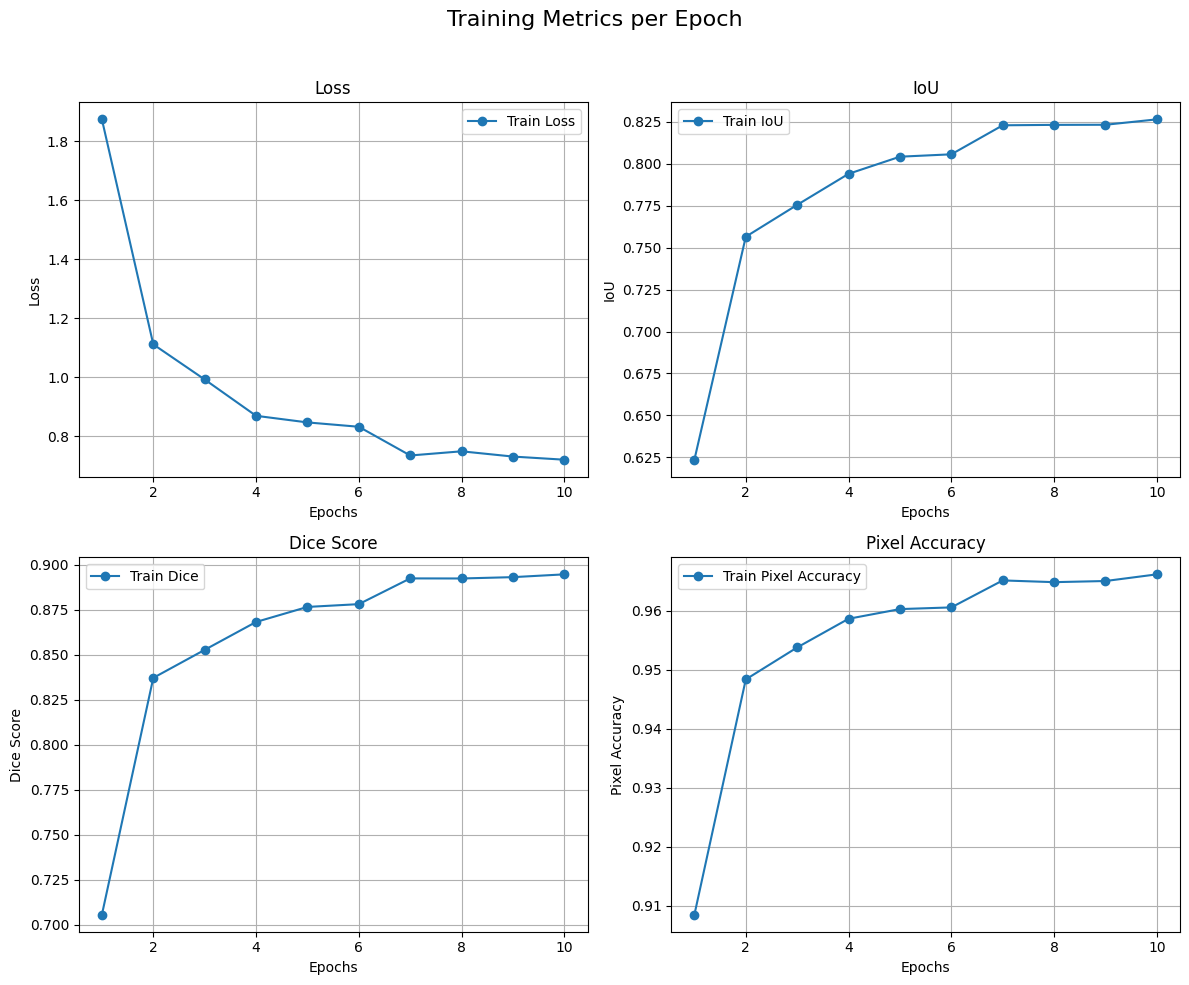

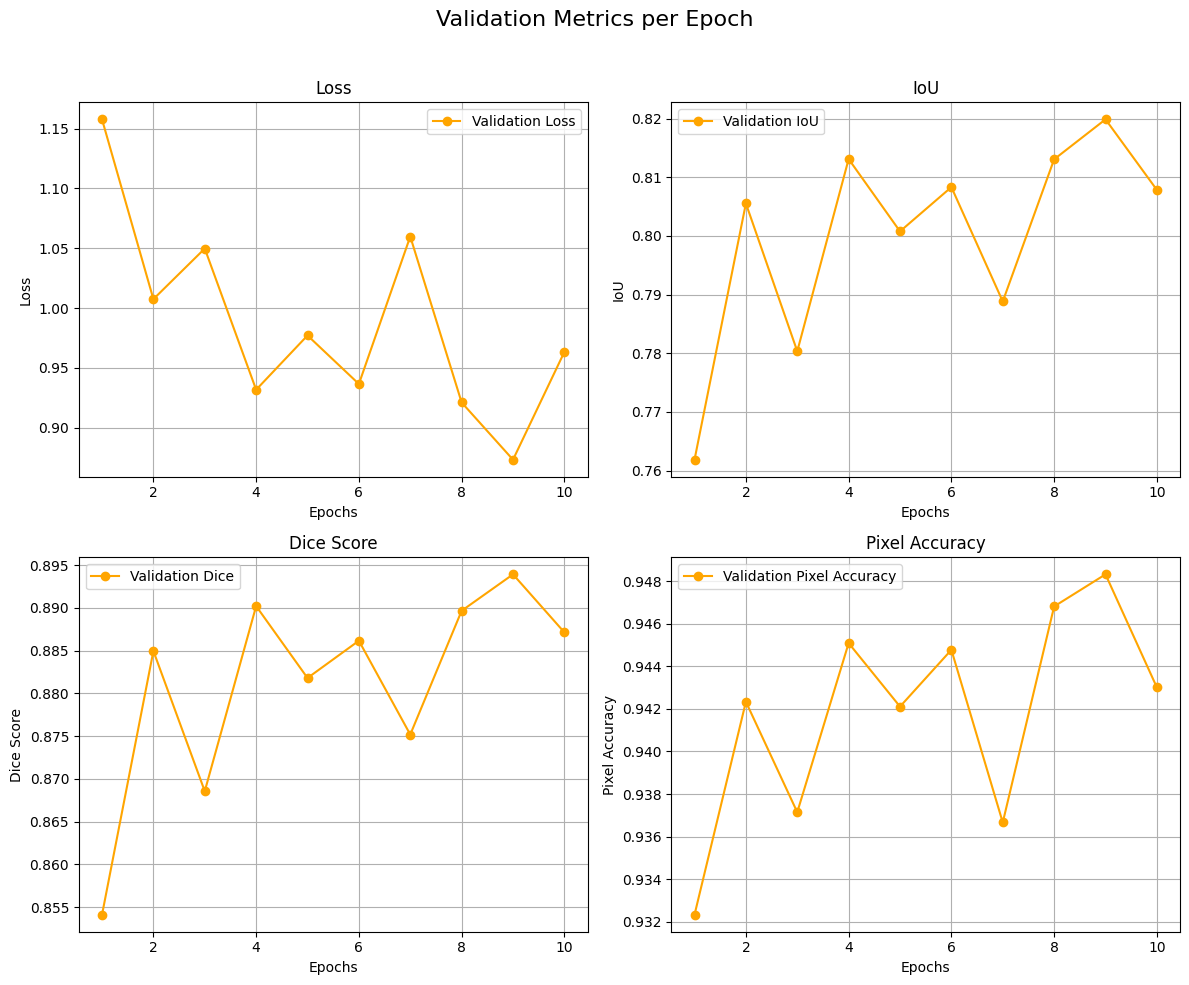

In [ ]:
# visualize results

visualize_training_metrics(train_metrics)
visualize_validation_metrics(val_metrics)


### Saving the Model Weights (necessary for further experiments)

Here we save the model weights (assuming saving to google drive) for future use. This will be necessary when performing experiments because we will need the activations and layer outputs of the model which will require inference using the trained model.

The save_model functions is part of the utils.py file--please navigate for further information.



In [ ]:
############################
# Saving the Model/Weights #
############################

# location for saved model
save_path = os.getcwd() + "/drive/MyDrive/mech_interp_segmentation/models/transformer/mask2former_epoch10_batch16"

# save model
save_model_and_processor_mask2former(model=model, image_processor=image_processor, save_dir=save_path)


Model and image processor saved to /content/drive/MyDrive/mech_interp_segmentation/models/transformer/mask2former_epoch10_batch16


### Final Inference, Testing, and Visual Display

Finally, we perform inference on unseen data and visualize the results in order to ensure that the model is not "cheating" by predicting background pixels where tissue should be to increase metrics.

We use the entirety of the testing as this will also be our final testing of the model to verify generalization after training. The test set has 20% of the samples in the training set --500 images. The inferencing method will display all the same metrics as the training methods above (mIOU, dice loss, and pixel accuracy). However, the method will also display the original processed image, corresponding the ground truth mask, and corresponding predicted mask for each sample to allow visual inspection of the model's performance which is a crucial component of model evaluation in a medical segmentation task such as this one.

---

<br>

The functions for loading the model and processor are from utils.py.

We then use inference_and_display from inference.py which performs inference on the given dataloader and takes the number of samples for comparison as an argument.

The function then displays, for each sample, the each original processed image, corresponding the ground truth mask, and corresponding predicted mask.

When all samples are displayed, the function will display the mIOU, pixel accuracy, and dice.

<br

---

**Quantitative Performance on the Test Set**  
- **Mean IoU**: 0.8034  
- **Mean Dice**: 0.8835  
- **Mean Pixel Accuracy**: 0.9297  

These metrics demonstrate that the model effectively segments lesions with high overlap (Dice and IoU) and correctly classifies the majority of pixels (Pixel Accuracy).

---

**Qualitative Observations**  
- **Example Sample (Image #500)**:  
  - The **original image** exhibits subtle color gradations and varying skin tones.  
  - The **ground truth mask** accurately highlights the lesion area.  
  - The **predicted mask** closely aligns with the ground truth, although minor discrepancies in peripheral regions may exist.  
- Overall, the visual results across multiple samples confirm that the model is not “cheating” by over-predicting background. The predicted masks consistently capture the lesion boundaries with minimal false positives or negatives.

---

**Conclusion**  
These test results indicate that the model generalizes well to unseen data, achieving strong performance on the ISIC 2018 dataset. The combination of high IoU, Dice, and Pixel Accuracy—along with visually coherent segmentations—validates the model’s reliability and robustness for medical image segmentation tasks.

In [ ]:
###############################
# Model Inference and Display #
###############################


# use validation set (100 unseen images) -> not used during training
# not used because familiar with mask2former for binary segmentation of tissue
# and chose hyperparameters based on heuristics and experience
# MIoU of 0.8, pixel accuracy of 0.95
# these are good for us because we are not concerned with a few extra points
# of accuracy metrics, we are itnerested in mechanisitc interpretability of the model


# load model for inference
model_inference, image_processor_inference = load_model_and_processor_mask2former(save_path)

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_inference.to(device)


# inference and display

infer_and_display_mask2former(model_inference, image_processor_inference, test_loader, device, num_samples=500, target_size=(256, 256))




Output hidden; open in https://colab.research.google.com to view.